In [1]:
import sqlite3
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
#from matplotlib import cm
%matplotlib inline

# Exloring Database through Pandas

In [2]:
db = 'chinook_v2.db'
conn = sqlite3.connect(db) #instantiate a connector object
q = '''
    SELECT *
    FROM sqlite_master
    WHERE type IN ("table","view");
    '''

pd.read_sql_query(q, conn ) #function to read queries through pandas and render them into dataframes

,type,name,tbl_name,rootpage,sql
0,table,album,album,2,CREATE TABLE [album]\n(\n [album_id] INTEGE...
1,table,artist,artist,3,CREATE TABLE [artist]\n(\n [artist_id] INTE...
2,table,customer,customer,4,CREATE TABLE [customer]\n(\n [customer_id] ...
3,table,employee,employee,5,CREATE TABLE [employee]\n(\n [employee_id] ...
4,table,genre,genre,6,CREATE TABLE [genre]\n(\n [genre_id] INTEGE...
5,table,invoice,invoice,7,CREATE TABLE [invoice]\n(\n [invoice_id] IN...
6,table,invoice_line,invoice_line,8,CREATE TABLE [invoice_line]\n(\n [invoice_l...
7,table,media_type,media_type,9,CREATE TABLE [media_type]\n(\n [media_type_...
8,table,playlist,playlist,10,CREATE TABLE [playlist]\n(\n [playlist_id] ...
9,table,playlist_track,playlist_track,11,CREATE TABLE [playlist_track]\n(\n [playlis...


# Defining helper functions

In [3]:
#By setting up "contexts" with WITH clause, we avoid issues
#It is a context manager - it opens and closes the db within the function itself


def run_query(q):
    with sqlite3.connect(db) as conn: 
        return pd.read_sql(q, conn)

def run_command(c):
    with sqlite3.connect(db) as conn:
        conn.isolation_level = None #autocommit any changes
        conn.execute(c)

def show_tables():
    q = '''
    SELECT
        name,
        type
    FROM sqlite_master
    WHERE type IN ("table","view");
    '''
    return run_query(q)

In [4]:
show_tables().T

,0,1,2,3,4,5,6,7,8,9,10
name,album,artist,customer,employee,genre,invoice,invoice_line,media_type,playlist,playlist_track,track
type,table,table,table,table,table,table,table,table,table,table,table


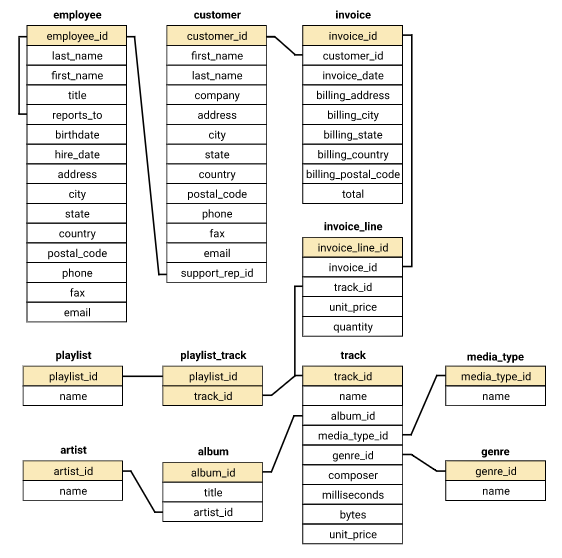

In [5]:
#printing out the chinook db schema for reference
from IPython.display import Image
Image(filename='chinook-schema.png') 

# Artist onboarding
We have a list of new artists that are ready to sign a contract with us but unsurprisingly we have budget constraints - considering the genres that are rocking the most in the US, we should aim to find those who are listened the most.
Let's now 
- **write a query to find out which genres sell the most tracks in the USA**
-  create a visualization of that data using pandas.


In [6]:
d = {'artist': ["Regal", "Red Tone", "Meteor and the Girls","Slim Jim Bites"], 
     'genre': ["Hip-Hop","Punk", "Pop", "Blues"]
    }
new_artists = pd.DataFrame(data=d)
new_artists

,artist,genre
0,Regal,Hip-Hop
1,Red Tone,Punk
2,Meteor and the Girls,Pop
3,Slim Jim Bites,Blues


In [7]:
q1 ='''
    WITH us_market AS(
        SELECT
            g.name AS genre,
            COUNT(il.invoice_line_id) AS number_of_tracks
        FROM genre AS g
            INNER JOIN track AS t ON g.genre_id = t.genre_id
            INNER JOIN invoice_line AS il ON t.track_id = il.track_id
            INNER JOIN invoice AS i ON il.invoice_id = i.invoice_id
            INNER JOIN customer AS c ON i.customer_id = c.customer_id
        WHERE c.country = "USA"
        GROUP BY 1
        ORDER BY 2 DESC)
    
    SELECT 
        genre,
        number_of_tracks,
        (CAST(number_of_tracks AS FLOAT) / (SELECT SUM(number_of_tracks) from us_market)) as percentage
    FROM us_market
    
    '''
top_genres_us = run_query(q1)

#for easier analysis
top_10_us = top_genres_us.head(10)

top_genres_us.head(10)


,genre,number_of_tracks,percentage
0,Rock,561,0.533777
1,Alternative & Punk,130,0.123692
2,Metal,124,0.117983
3,R&B/Soul,53,0.050428
4,Blues,36,0.034253
5,Alternative,35,0.033302
6,Latin,22,0.020932
7,Pop,22,0.020932
8,Hip Hop/Rap,20,0.019029
9,Jazz,14,0.013321


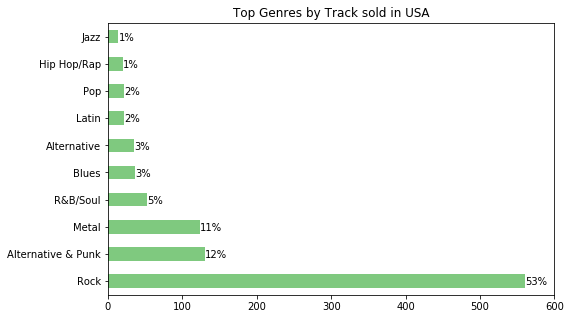

In [8]:
#generate graph from dataframe
top_10_us[["genre","number_of_tracks"]].plot(kind="barh",
                                 figsize=(8,5),     #define size of figure
                                 x="genre",         #used to avoid labels on index
                                 cmap= plt.cm.Accent,
                                 title = "Top Genres by Track sold in USA",
                                 legend = None,
                                 xlim = (0,600))

#Add some styling. Remove y label and add labels 
plt.ylabel('')


#Draw labels and info
for i in enumerate(top_10_us.index):                        #enumerate used on iterable to get list of integers
    index = i[0]                                            #select only one item of the tuple, returning the index for each row
    x_coords = top_10_us.loc[index, "number_of_tracks"]     #retrieve number_of_tracks as x coordinate
    label = (top_10_us.loc[index, "percentage"]*100).astype(int).astype(str) + "%" #retrieve percentages as labels of the bars
    plt.annotate(label, (x_coords + 0.20, index - 0.15))    #draw annotations as per string, (x,y) syntax
plt.show()


In light of the findings, it looks like our best bet stands in the **Red Tone** band, with their punk vibes. We might as well spend some of that budget to scout for Rock bands, since they are so popular!

# Sales support analysis
Which are the most performing sales agents out there?


In [9]:
q2 = '''WITH emp_revenue AS
        (SELECT 
            c.support_rep_id,
            SUM(i.total) as revenue
                FROM invoice AS i
                LEFT JOIN customer AS c
                ON i.customer_id = c.customer_id
            GROUP BY 1)
    
    SELECT 
        CAST(er.support_rep_id AS string) AS employee_id,
        e.first_name || " " || e.last_name as employee_name,
        e.title,
        e.hire_date,
        e.birthdate,
        er.revenue
    FROM employee AS e
    INNER JOIN emp_revenue AS er
    ON e.employee_id = er.support_rep_id

'''

employees = run_query(q2)
employees

,employee_id,employee_name,title,hire_date,birthdate,revenue
0,3,Jane Peacock,Sales Support Agent,2017-04-01 00:00:00,1973-08-29 00:00:00,1731.51
1,4,Margaret Park,Sales Support Agent,2017-05-03 00:00:00,1947-09-19 00:00:00,1584.00
2,5,Steve Johnson,Sales Support Agent,2017-10-17 00:00:00,1965-03-03 00:00:00,1393.92


The selection of columns we take starts from the reasonable assumption that revenue generated by Sales Agents can be either based on their Hire Date (the more experienced they are, the better at selling) or on their BirthDate (younger employees resonate better with customers?).  
We'll check **correlation coefficients along the parts and verify whether we can find some evidence**.
In order to do so, it is mandatory for us to convert HireDate and BirthDate to discrete timeframes (years).

In [10]:
#convert datetimes to differences and define years of service
today = pd.to_datetime('today')

for i in range(0,2):
    new_cols = ["from_hiring", "from_birth"]
    existing = ["hire_date", "birthdate"]
    employees[new_cols[i]] = (today - pd.to_datetime(employees[existing[i]])) #define new columns as timedeltas
employees

,employee_id,employee_name,title,hire_date,birthdate,revenue,from_hiring,from_birth
0,3,Jane Peacock,Sales Support Agent,2017-04-01 00:00:00,1973-08-29 00:00:00,1731.51,912 days 19:41:31.282469,16833 days 19:41:31.282469
1,4,Margaret Park,Sales Support Agent,2017-05-03 00:00:00,1947-09-19 00:00:00,1584.00,880 days 19:41:31.282469,26309 days 19:41:31.282469
2,5,Steve Johnson,Sales Support Agent,2017-10-17 00:00:00,1965-03-03 00:00:00,1393.92,713 days 19:41:31.282469,19934 days 19:41:31.282469


In [11]:
#unclean but forgive me
employees["from_hiring"] = employees["from_hiring"].apply(lambda x: x.days/365) #convert colums to year count
employees["from_birth"] = employees["from_birth"].apply(lambda x: x.days/365) #convert colums to year count

employees

,employee_id,employee_name,title,hire_date,birthdate,revenue,from_hiring,from_birth
0,3,Jane Peacock,Sales Support Agent,2017-04-01 00:00:00,1973-08-29 00:00:00,1731.51,2.498630,46.117808
1,4,Margaret Park,Sales Support Agent,2017-05-03 00:00:00,1947-09-19 00:00:00,1584.00,2.410959,72.079452
2,5,Steve Johnson,Sales Support Agent,2017-10-17 00:00:00,1965-03-03 00:00:00,1393.92,1.953425,54.613699


In [12]:
corr = employees.iloc[:,5:8].corr()
corr.style.background_gradient(cmap='coolwarm').set_precision(2) #nice touch to create a colored matrix

,revenue,from_hiring,from_birth
revenue,1,0.96,-0.25
from_hiring,0.96,1,0.047
from_birth,-0.25,0.047,1


We nailed our suspicions!  
We find evidence of **extremely high correlation between Years of service and revenue generated**: the more you work, the better you get at your job! So cheers with Jane Peacock, that is rocking the sales for Chinook.

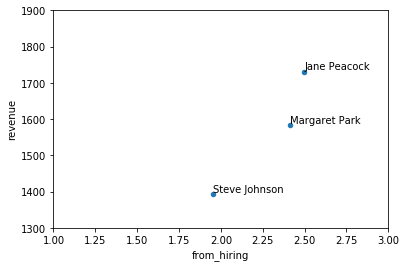

In [13]:
employees.plot(kind='scatter', x='from_hiring', y='revenue', ylim= (1300,1900), xlim = (1,3))

label = employees["employee_name"]
x = employees["from_hiring"]
y = employees["revenue"]

for i in range(0,3):
    plt.annotate(label[i], (x[i],y[i]+5))

# Analyzing Sales by Country
By using the country dimension into the customers table, we aim to find the contribution of each market, with a focus on:
- total number of customers --> COUNT(DISTINCT customerid)
- total value of sales --> SUM(unitprice)
- average value of sales per customer --> sales / number_of_customers
- average order value --> SUM(unitprice) / COUNT(DISTINCT invoicedid)

In order to do so we'll build two subqueries:  
1) Granular, containing track-level data, which we'll then aggregate  
2) Country, a subquery defining countries with the "other" clause

In [14]:
country_metrics = '''WITH granular AS
        (SELECT
            i.invoice_id,
            il.invoice_line_id,
            i.customer_id,
            c.country,
            il.unit_price
        FROM invoice_line AS il
            JOIN invoice AS i ON il.invoice_id = i.invoice_id
            JOIN customer AS c ON c.customer_id = i.customer_id),

        countries AS 
        (SELECT
            country,
            CASE WHEN (COUNT (DISTINCT customer_id)) = 1 THEN 'Other' ELSE country END as grouped_country
        FROM customer
        GROUP BY 1)

SELECT
    c.grouped_country,
    COUNT(DISTINCT g.customer_id) AS number_of_customers,
    SUM(g.unit_price) AS sales,
    ROUND(SUM(g.unit_price) / COUNT(DISTINCT g.customer_id),2) AS ARPU,
    ROUND(SUM(g.unit_price) / COUNT(DISTINCT g.invoice_id),2) AS average_invoice_value,
    CASE WHEN c.grouped_country = 'Other' THEN 1 ELSE 0 END AS fake_sort
FROM granular g
JOIN countries c
ON g.country = c.country
GROUP BY 1
ORDER BY fake_sort ASC, 2 DESC 
'''

store = run_query(country_metrics)

country_metrics = store.iloc[:,0:-1]
country_metrics

,grouped_country,number_of_customers,sales,ARPU,average_invoice_value
0,USA,13,1040.49,80.04,7.94
1,Canada,8,535.59,66.95,7.05
2,Brazil,5,427.68,85.54,7.01
3,France,5,389.07,77.81,7.78
4,Germany,4,334.62,83.66,8.16
5,United Kingdom,3,245.52,81.84,8.77
6,Czech Republic,2,273.24,136.62,9.11
7,India,2,183.15,91.58,8.72
8,Portugal,2,185.13,92.57,6.38
9,Other,15,1094.94,73.00,7.45


In [15]:
country_metrics.set_index("grouped_country", drop=True, inplace=True)
country_metrics

,number_of_customers,sales,ARPU,average_invoice_value
grouped_country,,,,
USA,13,1040.49,80.04,7.94
Canada,8,535.59,66.95,7.05
Brazil,5,427.68,85.54,7.01
France,5,389.07,77.81,7.78
Germany,4,334.62,83.66,8.16
United Kingdom,3,245.52,81.84,8.77
Czech Republic,2,273.24,136.62,9.11
India,2,183.15,91.58,8.72
Portugal,2,185.13,92.57,6.38


fig, axes = plt.subplots(nrows = 2, ncols=2, figsize=(10,10))

#add four subplots
for i in range(0,4):
    ax = fig.add_subplot(4,1,i+1)

plt.show()
#ax1,ax2,ax3,ax4 = axes

#country_metrics["sales"].plot.pie(title='Sales per Country', autopct='%1.1f%%')

#country_metrics["sales"].plot.pie(title='Sales per Country', autopct='%1.1f%%')


In [16]:
country_metrics["sales"]

grouped_country
USA               1040.49
Canada             535.59
Brazil             427.68
France             389.07
Germany            334.62
United Kingdom     245.52
Czech Republic     273.24
India              183.15
Portugal           185.13
Other             1094.94
Name: sales, dtype: float64

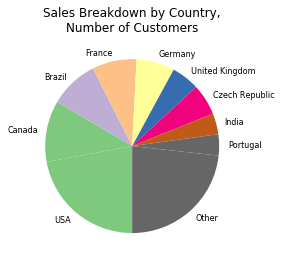

In [18]:
sales_breakdown = country_metrics["sales"].copy().rename('')
sales_breakdown.plot.pie(
    startangle=-90,
    counterclock=False,
    title='Sales Breakdown by Country,\nNumber of Customers',
    colormap=plt.cm.Accent,
    fontsize=8,
    wedgeprops={'linewidth':0})
plt.show()

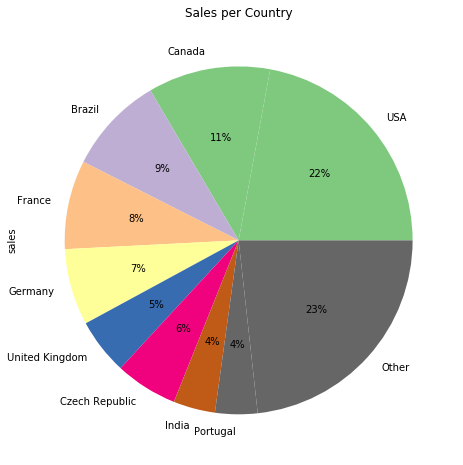

In [19]:
plt.figure(figsize=(8,8))

colors = [plt.cm.Accent(i) for i in np.linspace(0, 1, country_metrics.shape[0])]


country_metrics["sales"].plot.pie(title='Sales per Country', 
                                  autopct='%1.f%%',
                                  colormap=plt.cm.Accent
)


In [20]:
show_tables().T

,0,1,2,3,4,5,6,7,8,9,10
name,album,artist,customer,employee,genre,invoice,invoice_line,media_type,playlist,playlist_track,track
type,table,table,table,table,table,table,table,table,table,table,table


In [21]:
#write a further exploratory function to see content of tables
def show_table_records(table, number_of_rows):
    read = '''SELECT * FROM {t} LIMIT {n}'''.format(t=table, n=number_of_rows)
    return run_query(read)

In [22]:
show_table_records('Customer', 2)

,customer_id,first_name,last_name,company,address,city,state,country,postal_code,phone,fax,email,support_rep_id
0,1,Luís,Gonçalves,Embraer - Empresa Brasileira de Aeronáutica S.A.,"Av. Brigadeiro Faria Lima, 2170",São José dos Campos,SP,Brazil,12227-000,+55 (12) 3923-5555,+55 (12) 3923-5566,luisg@embraer.com.br,3
1,2,Leonie,Köhler,None,Theodor-Heuss-Straße 34,Stuttgart,None,Germany,70174,+49 0711 2842222,None,leonekohler@surfeu.de,5


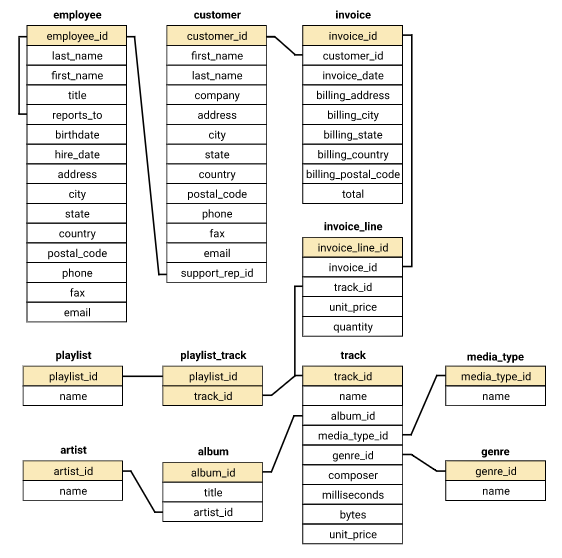

In [23]:
#printing out the chinook db schema for reference
from IPython.display import Image
Image(filename='chinook-schema.png') 

# Round 2
We have been asked to find out what percentage of purchases are individual tracks vs whole albums, so that management can use this data to understand the effect this decision might have on overall revenue.  
**In order to answer the question, we're going to have to identify whether each invoice has all the tracks from an album.**  
We can do this by getting the list of tracks from an invoice and comparing it to the list of tracks from an album. We can find the album to compare the purchase to by looking up the album that one of the purchased tracks belongs to.**


In [24]:
sql = '''

/* Build a table containing all album ids and the related amount of tracks */

WITH albums_and_tracks AS
    (SELECT
        a.album_id,
        COUNT(DISTINCT t.track_id) as album_tracks
        FROM album a
            JOIN track t ON a.album_id = t.album_id
        GROUP BY 1
        ),


/* Second table built up on invoices and containing albums and tracks purchased, as well as generated revenue*/

    invoice_and_albums AS
    (SELECT
        il.invoice_id,
        t.album_id,
        COUNT(DISTINCT il.track_id) as purchased_tracks,
        SUM(il.unit_price) as revenue
        FROM invoice_line il
            JOIN track t ON il.track_id = t.track_id
        GROUP BY 1,2
        
    )


/* Put subqueries together: the result is a dataframe that addresses each row as an album part of an invoice.
This allows to infer whether the album was a full purchase or not, and understand its %weight in generating revenue.
Notice that we exclude albums that are only 1 track long as contributing to */

        SELECT 
        iaa.invoice_id,
        iaa.album_id,
        iaa.purchased_tracks,
        iaa.revenue,
        aat.album_tracks,
        
        CASE WHEN iaa.purchased_tracks = aat.album_tracks AND aat.album_tracks>1 THEN 1 ELSE 0 END as full_album_purchased
            FROM invoice_and_albums iaa
            INNER JOIN albums_and_tracks aat ON aat.album_id = iaa.album_id
        ORDER BY 1 ASC
    '''

answer = run_query(sql)
answer

,invoice_id,album_id,purchased_tracks,revenue,album_tracks,full_album_purchased
0,1,91,16,15.84,16,1
1,2,20,1,0.99,11,0
2,2,34,1,0.99,17,0
3,2,39,1,0.99,21,0
4,2,66,1,0.99,10,0
5,2,73,1,0.99,30,0
6,2,134,1,0.99,10,0
7,2,190,1,0.99,16,0
8,2,215,1,0.99,14,0
9,2,218,1,0.99,15,0


In [25]:
answer.iloc[:,-1].value_counts()

0    2966
1     111
Name: full_album_purchased, dtype: int64

In [26]:
adf = answer.pivot_table(values=["revenue","album_id"],
                   index="full_album_purchased",
                   aggfunc={'revenue':'sum', 'album_id':'count'})

#calculate percentage values
adf['percentage_revenue'] = adf["revenue"] / adf["revenue"].sum()
adf['percentage_albums'] = adf["album_id"] / adf["album_id"].sum()

#rename column
adf = adf.rename(columns={"album_id": 'albums_sold'})

#print dataframe
#adf.reset_index(inplace = True)
adf

,albums_sold,revenue,percentage_revenue,percentage_albums
full_album_purchased,,,,
0,2966,3251.16,0.690351,0.963926
1,111,1458.27,0.309649,0.036074


<BarContainer object of 2 artists>

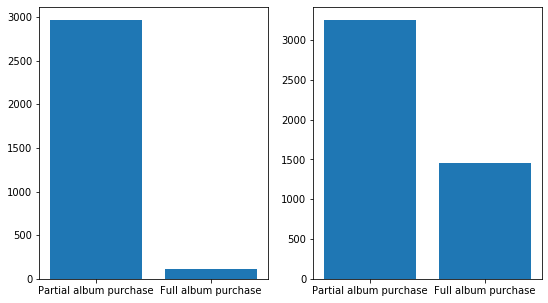

In [28]:
columns = ["albums_sold", "revenue"]
volumes = adf["albums_sold"]
revenue = adf["revenue"]

index = ["Partial album purchase", "Full album purchase"]

plt.figure(figsize=(9,5))

#first graph
plt.subplot(121)
plt.bar(index, volumes)


#second graph
plt.subplot(122)
plt.bar(index, revenue)

# test = adf[columns].copy()
# #test.index.name = ''

# fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10,2))
# for i in columns:
#     test[i].plot.bar()
# #adf.plot.bar({'albums_sold':albs, 'revenue':rev}, index)

adf.plot.bar()

# A python-based solution to the query above

Aside of the convenient SQL solution, we want to try and solve the same business problems running some Python. The approach we take is to:
- Build a **master_dict** ```{invoice_id: {album_id : [track_id]}``` that covers for each invoice which albums were purchased, and therein which tracks.  
- Build a **album_tracks_map** ``` {album_id : [list_of_track_ids]}``` containing a full mapping of all the album sold by Chinook.

By comparing these two dictionaries, we can find out how many full albums we have sold.  
Note that this is mostly an exercise, and proved to be more challenging and less scalable than the SQL solution covered before (e.g. it does not allow us to understand value for each tracks).


### Building master_dict
Prep entry data by running a sql query that generated the beginning dataframe.

In [29]:
q = '''
SELECT
    il.invoice_id,
    t.album_id,
    il.track_id
FROM invoice_line il
    JOIN track t ON t.track_id = il.track_id
'''

df = run_query(q)
df

,invoice_id,album_id,track_id
0,1,91,1158
1,1,91,1159
2,1,91,1160
3,1,91,1161
4,1,91,1162
5,1,91,1163
6,1,91,1164
7,1,91,1165
8,1,91,1166
9,1,91,1167


In [30]:
master_dict={}
unique_invoices = df["invoice_id"].unique().tolist()

#build a dict of dicts with the following structure:
# {invoiceId: {albumId:[trackid1, trackid_n]  }  }

for i in unique_invoices:
    album_dict = {}                  #for each unique invoice generate an empty album dictionary... 
    master_dict[i] = album_dict      #...and push it into the master dict, creating a nested structure
    ref_df = df[df["invoice_id"] == i]                #generate subset of data for each invoice (all rows under same invoice)
    album_list = ref_df["album_id"].unique().tolist()     #select unique albums purchased per invoice

    for alb_id in album_list:                          #for each unique album purchased (in each invoice - nested loop)
        sub_ref = ref_df[ref_df["album_id"] == alb_id] #generate subset of data
        track_list = sub_ref["track_id"].tolist()      #identify purchased tracks per album and reduce to list
        album_dict[alb_id] = track_list                #populate album_dict >>> Key:value --> Album_id: Track_list

master_dict[1]

{91: [1158,
  1159,
  1160,
  1161,
  1162,
  1163,
  1164,
  1165,
  1166,
  1167,
  1168,
  1169,
  1170,
  1171,
  1172,
  1173]}

### Building album_tracks_map
Prep entry data by running a sql query that generated the beginning dataframe.

In [31]:
#retrieve full list of tracks per album
q = '''
SELECT
    al.album_id,
    al.title,
    t.track_id,
    t.name
FROM album al 
    INNER JOIN track t on t.album_id = al.album_id
ORDER BY 1,3
'''
albums = run_query(q)
run_query(q)

,album_id,title,track_id,name
0,1,For Those About To Rock We Salute You,1,For Those About To Rock (We Salute You)
1,1,For Those About To Rock We Salute You,6,Put The Finger On You
2,1,For Those About To Rock We Salute You,7,Let's Get It Up
3,1,For Those About To Rock We Salute You,8,Inject The Venom
4,1,For Those About To Rock We Salute You,9,Snowballed
5,1,For Those About To Rock We Salute You,10,Evil Walks
6,1,For Those About To Rock We Salute You,11,C.O.D.
7,1,For Those About To Rock We Salute You,12,Breaking The Rules
8,1,For Those About To Rock We Salute You,13,Night Of The Long Knives
9,1,For Those About To Rock We Salute You,14,Spellbound


In [33]:
#build a mapping dictionary with the following structure:
# {albumId: [tracks]}
album_tracks_map = dict()
for i in albums['album_id'].unique().tolist():  #generate list of unique albumIds and iterate through them
    bool_filter = albums['album_id'] == i       #for each albumId generate a boolean filter evaluating each row (song)
    alb_slice = albums[bool_filter]             #generate a DF containing list of songs for each album
    album_tracks_map[i] = alb_slice['track_id'].tolist() #add to dictionary list of tracks as VALUES per each KEY (albumId)
    
album_tracks_map[1]

[1, 6, 7, 8, 9, 10, 11, 12, 13, 14]

### Run dictionary comparison

In [34]:
#working code
full_albums_purchased = []

for invoice, album in master_dict.items():
    #album is the list of values in master_dict. It is configured as {purchased_album_id : [purchased_track_ids]}
    for album_id, purchased_tracks in album.items(): #access album -the nested dictionary containing purchased albums and tracks
        comparison = album_tracks_map[album_id]   #access the list of tracks in each album full version (from the map dict)
        if set(purchased_tracks) == set(comparison) and len(purchased_tracks) > 1:
            full_albums_purchased.append(True)
        else:
            full_albums_purchased.append(False)

pd.Series(full_albums_purchased).value_counts()


False    2965
True      112
dtype: int64